In [9]:
import os
import torch
import random

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms

from eval import accuracy
from model import MnistCNN
from train import fit, evaluate
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

In [3]:
BATCH_SIZE = 100
NUM_CLASSES = 10
INPUT_SIZE = 28 * 28
DATASET = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [30]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)

    idxs = np.random.permutation(n)

    return idxs[n_val:], idxs[:n_val]

train_indexes, validation_indexes = split_indices(len(DATASET), 0.2)

train_sampler = SubsetRandomSampler(train_indexes)
train_loader = DataLoader(DATASET, BATCH_SIZE, sampler=train_sampler)

val_sampler = SubsetRandomSampler(validation_indexes)
val_loader = DataLoader(DATASET, BATCH_SIZE, sampler=val_sampler)

loss_fun = F.cross_entropy

def predict_image(image, model):
    xb = image.unsqueeze(0).to(dev)
    yb = model(xb)
    yb = yb.to(dev)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

def plot_graph(acc_list, lost_list, title):
    plt.plot(np.arange(0.0, 1.0, 0.1), acc_list, '-b', label='accuracy')
    plt.plot(np.arange(0.0, 1.0, 0.1), lost_list, '-r', label='loss')
    plt.legend(loc='upper left')
    plt.xlabel("amount pruned")
    plt.title(title)
    plt.show()


In [31]:
if not os.path.isfile('model.pt'):
    model = MnistCNN().to(dev)
    learning_rate = 0.001
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    fit(10, model, loss_fun, optimizer, train_loader, val_loader, accuracy)

    torch.save(model.state_dict(), 'model.pt')
else:
    model = MnistCNN()
    model.load_state_dict(torch.load('model.pt'))
    model.to(dev)

In [32]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=200)
test_loss, total, test_acc = evaluate(model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Loss: 0.1468, accuracy: 0.9571


In [33]:
params_to_prune = [
    (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules())
]

acc = []
lss = []

for num in np.arange(0.0, 1.0, 0.1):
    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=num
    )

    test_loader = DataLoader(test_dataset, batch_size=200)
    test_loss, total, test_acc = evaluate(model, loss_fun, test_loader, metric=accuracy)
    print(f"Amount pruned: {num:.1f}, Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    acc.append(test_acc)
    lss.append(test_loss)

Amount pruned: 0.0, Loss: 0.1468, accuracy: 0.9571
Amount pruned: 0.1, Loss: 0.1481, accuracy: 0.9568
Amount pruned: 0.2, Loss: 0.1668, accuracy: 0.9476
Amount pruned: 0.3, Loss: 0.2013, accuracy: 0.9393
Amount pruned: 0.4, Loss: 0.4019, accuracy: 0.8710
Amount pruned: 0.5, Loss: 0.8660, accuracy: 0.7178
Amount pruned: 0.6, Loss: 1.2497, accuracy: 0.5889
Amount pruned: 0.7, Loss: 2.7956, accuracy: 0.1153
Amount pruned: 0.8, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.9, Loss: 2.6539, accuracy: 0.1135


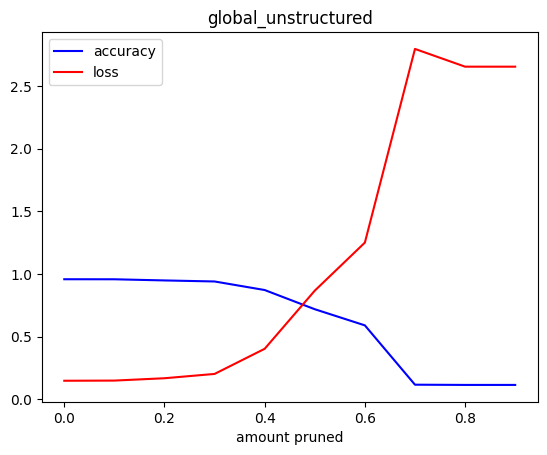

In [34]:
plot_graph(acc, lss, 'global_unstructured')